# Clustering of Stackoverflow Users
by [Jon-Kashmir Colipapa](https://gitlab.datascience.aim.edu/jcolipapa)

## Executive Summary:

__The goal of this write-up is to attempt to be able to determine the different types of users__ in the popular programming help site: [__stackoverflow.com__](https://stackoverflow.com) according the tags used on the posts that they comment on.

Data on the posts as well as the comments have already been gathered by the AIM Access lab and is stored in 2 files: __Comments.xml__ and __Posts.xml__. We then parse the data using the lxml etree parser and obtain the tags used per post as well as the users commenting on those posts. 

As the data is relatively huge, for computational efficiency purposes, we performed random sampling to limit the users to 1100. 

Clustering was done using sklearn's MiniBatchKmeans which is alternative to the popular clustering algorithm K-Means. We then use 3 internal clustering validation techniques that allow us to measure the goodness of the clustering and ultimately determine the best cluster count for our data.

Using the above methodology, __we have found that the best clustering happens when you have 4 clusters__. On what these clusters are and how we were able to come up with this result, see below for a more details. 

## Parsing the XML Data

#### Load the necessary library for parsing xml

In [1]:
from lxml import etree

#### Specify locations of the xml files

In [2]:
comms = '/mnt/data/public/stackoverflow/Comments.xml'
posts = '/mnt/data/public/stackoverflow/Posts.xml'

#### get sample post to have a feel on the content

In [3]:
temp = etree.iterparse(posts)
l = next(temp)
print('Sample Post:')
print(l[1].attrib)
print()
temp = etree.iterparse(comms)
l = next(temp)
print('Sample Comment:')
print(l[1].attrib)

Sample Post:
{'Id': '4', 'PostTypeId': '1', 'AcceptedAnswerId': '7', 'CreationDate': '2008-07-31T21:42:52.667', 'Score': '543', 'ViewCount': '34799', 'Body': "<p>I want to use a track-bar to change a form's opacity.</p>\n\n<p>This is my code:</p>\n\n<pre><code>decimal trans = trackBar1.Value / 5000;\nthis.Opacity = trans;\n</code></pre>\n\n<p>When I build the application, it gives the following error:</p>\n\n<blockquote>\n  <p>Cannot implicitly convert type <code>'decimal'</code> to <code>'double'</code>.</p>\n</blockquote>\n\n<p>I tried using <code>trans</code> and <code>double</code> but then the control doesn't work. This code worked fine in a past VB.NET project.</p>\n", 'OwnerUserId': '8', 'LastEditorUserId': '3151675', 'LastEditorDisplayName': 'Rich B', 'LastEditDate': '2017-09-27T05:52:59.927', 'LastActivityDate': '2018-02-22T16:40:13.577', 'Title': 'While applying opacity to a form, should we use a decimal or a double value?', 'Tags': '<c#><winforms><type-conversion><decimal><o

### Parse comments and Posts
Extract Post __Id__ and __Tags__ for each _Post_. 
Extract __PostID__ and __UserID__ for each _Comment_.

In [4]:
i = 0
N_iter = 500000
comm_postID = []
comm_userID = []

post_ID = []
post_tags = []

for ((event1, element1), (event2, element2)) in zip(etree.iterparse(comms), 
                                                    etree.iterparse(posts)):

    if {'PostId', 'UserId'}.issubset(set(element1.attrib.keys())):
        comm_postID.append(element1.attrib['PostId'])
        comm_userID.append(element1.attrib['UserId'])

    if {'Tags', 'Id', }.issubset(set(element2.attrib.keys())):
        post_ID.append(element2.attrib['Id'])
        post_tags.append(element2.attrib['Tags'])

    i += 1
    if i >= N_iter:
        break        

#### Store results in pandas dataframe

In [5]:
import pandas as pd
import numpy as np

df_comm = pd.DataFrame({'comm_postID' : comm_postID,
              'comm_userID' : comm_userID})

df_post = pd.DataFrame({'post_ID' : post_ID,
              'post_tags' : post_tags})


#### Write parsing results to csv file for future use

In [6]:
df_post.to_csv('posts.csv')

In [7]:
df_comm.to_csv('comm.csv')

#### Reload the csv files

In [8]:
import pandas as pd
import numpy as np

df_post = pd.read_csv('posts.csv')
df_comm = pd.read_csv('comm.csv')

In [9]:
display(df_post.head())
display(df_comm.head())

,Unnamed: 0,post_ID,post_tags
0,0,4,<c#><winforms><type-conversion><decimal><opacity>
1,1,6,<html><css><css3><internet-explorer-7>
2,2,9,<c#><.net><datetime>
3,3,11,<c#><datetime><time><datediff><relative-time-s...
4,4,13,<javascript><html><browser><timezone><timezone...


,Unnamed: 0,comm_postID,comm_userID
0,0,35314,1
1,1,35314,3
2,2,35195,380
3,3,47239,4550
4,4,45651,242


#### Drop unneeded columns

In [10]:
df_post.drop(columns=['Unnamed: 0'], inplace=True)
df_comm.drop(columns=['Unnamed: 0'], inplace=True)

#### Remove <> from the post_tags 

In [11]:
lst = df_post['post_tags'].tolist()
df_post['post_tags'] = [s.replace('><', ' ').strip('<').strip('>') for s in lst]

#### JOIN the post and comments dataframes on POST_ID

In [12]:
df_comm.columns = ['post_ID', 'user_ID']
df_post_comm = pd.merge(df_post, df_comm, on='post_ID')

#### Create a new dataframe for users and the tags used on posts they commented on

In [13]:
df_user = pd.DataFrame(columns=['userID', 'post_tags'])
df_user['userID'] = df_post_comm.user_ID.unique()

### Random Sampling to minimize data set size.

#### Determine sample size needed for Confidence Interval=95% and Error Margin of 3%.

This formula can compute for appropriate sample size depending on Confidence Interval and desired margin of error. This formula is independent of population size for as long as population size is greater than 1000. Although counter intuitive, this formula actually increases in accuracy as population size increases. 

In [14]:
from scipy import stats

CI =0.95 # confidence interval
ERR=0.03 # error margin

Z=stats.norm.ppf(1-((1-CI)/2)) 
n=Z**2/(4*(ERR**2))

print("sample n needed= {}".format(n))

sample n needed= 1067.0718946372572


#### Perform Random sampling for the user IDs

In [15]:
df_user = df_user.sample(1100, random_state=0) #instead of using 1067 we just round it 1100 for convenience.

In [16]:
df_user.head()

,userID,post_tags
6813,64740,NaN
5527,42108,NaN
4912,44437,NaN
3724,37143,NaN
6860,62255,NaN


#### Create a function to join all post_tags for all posts commented by a given user

In [17]:
def get_post_tags(userID):
    s = ' '.join(df_post_comm.loc[df_post_comm['user_ID']==userID]['post_tags'].tolist())
    return(s)

# testing...
get_post_tags(3)

'asp.net-mvc throttling asp.net asp.net-mvc performance webforms vim emacs viper vimpulse c# design events asp.net download connection webclient asp.net-mvc html-helper renderpartial asp.net windows-mobile mobile viewstate database memory footprint winapi powershell volume mute asp.net regex http http-headers parsing compiler-construction c# msbuild msbuild-task invalidoperationexception c# include directory copy java jvm stack heap java database soap sybase reliability c# .net math matrix mathdotnet jquery ajax json firefox rest linq-to-sql ruby-on-rails ruby helper view-helpers c# .net algorithm cocoa macos isight visual-studio-2008 crash add-in .net linq data-access-layer jquery asp.net-mvc c# asp.net datagrid css internet-explorer firefox font-size c# .net oracle stored-procedures plsql'

#### Apply the new function for each user in the user dataframe

In [18]:
df_user['post_tags'] = df_user.apply(lambda row: get_post_tags(row.userID), axis=1)

In [19]:
df_user.head()

,userID,post_tags
6813,64740,c# entity-framework
5527,42108,sql sharepoint
4912,44437,java encryption load cpu
3724,37143,functional-programming nlp
6860,62255,image firefox png width line java video encode...


### Vectorize the post_tags in the df_user table into a bag-of-words (bows)

In order to perform clustering, we will need to express the post tags in vector form where each element in the vector are the words found in the entire corpus or in this case the entire set of entries in the post_tags column. We do this conveniently by using __sklearn's TFIDFVectorizer class__. 

Here, instantiating the TfidfVectorizer class we use the parameter: *max_features* (The maximum number of words that will be used to "profile" each post_tags entry). We then store the result in our bows (bag-of-words) variable which is a dataframe representation of our vector matrix.

For more details on the TfidfVectorizer class see: http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

vectorizer = TfidfVectorizer(max_features=2000)
# vectorizer = CountVectorizer(token_pattern='[^\s]+', min_df=0.01)
bows = vectorizer.fit_transform(df_user['post_tags'])

bows = pd.DataFrame(bows.todense())
bows.head()

,0,1,2,3,4,5,6,7,8,9,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
bows.shape

(1100, 2000)

## Use PCA to Visualize in 2D and 3D

In order to appreciate the concept of clustering, we need to be able to __visualize our multidimensional data in a way that we humans are normally able ~ in 2 or 3 dimensions.__ 

In order to do this, we __use PCA (Principal Component Analysis)__ to rotate our data in such a way that the most variance can be explained. In short, we will be __projecting our data to the first 2 or 3 dimensions called Principal Components__.

In [41]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA()
sk_pca = pca.fit_transform(bows)
sk_res = pd.DataFrame(sk_pca)

### Visualize in 2D

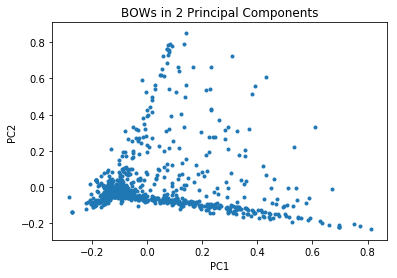

In [42]:
# fig, ax = plt.subplots(subplot_kw=dict(aspect='equal'))
fig, ax = plt.subplots()
ax.scatter(sk_res[0], sk_res[1], marker='.');
ax.set_title("BOWs in 2 Principal Components")
ax.set_xlabel('PC1')
ax.set_ylabel('PC2');

### Visualize in 3D

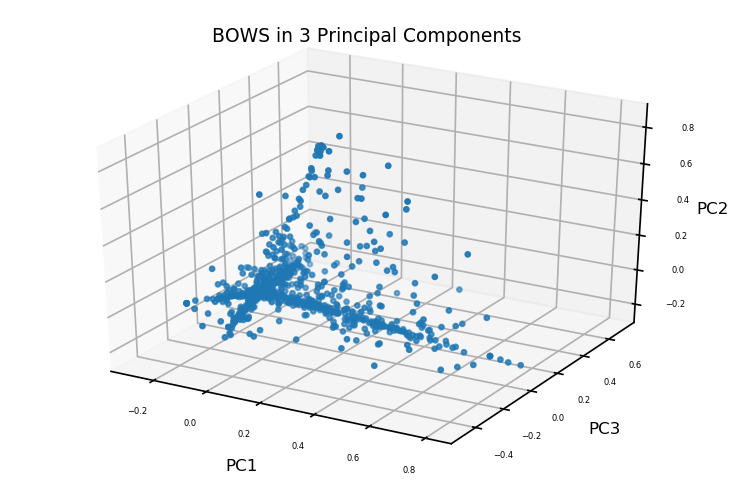

In [43]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

fig = plt.figure(dpi=150)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(sk_res[0], sk_res[2], sk_res[1], marker='.')
ax.tick_params(axis='both', which='major', labelsize=4)
ax.set_title("BOWS in 3 Principal Components", fontsize=9)
ax.set_xlabel('PC1', fontsize=8)
ax.set_ylabel('PC3', fontsize=8)
ax.set_zlabel('PC2', fontsize=8, labelpad=-1);

### Checking for Variance Explained

When we do dimensionality reduction, there is always that caveat of information loss. In order to have an idea of how much our 2D or 3D representations really represent of the entire data, we use a scree plot to __check for variance explained.__

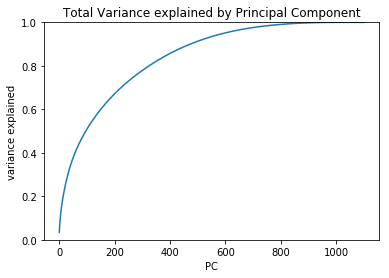

In [44]:
#cumulative variance explained
plt.plot(pca.explained_variance_ratio_.cumsum())
plt.ylim(0,1)
plt.title("Total Variance explained by Principal Component")
plt.xlabel('PC')
plt.ylabel('variance explained');

### Reduce Dimensionality based on scree plot
Based on the scree plot above, we see that we can further reduce our number of dimensions to 800 yet still retain about 100% variance explained.

In [45]:
sk_res = sk_res.iloc[:, 0:800]

### Using MiniBatchKMeans for Clustering

Sklearn's __MiniBatchKMeans__ is an alternative to K-means which is a method of vector quantization, originally from signal processing, that is popular for cluster analysis in data mining. __K-means and MiniBatchKMeans clustering aims to partition n observations into k clusters in which each observation belongs to the cluster with the nearest mean, serving as a prototype of the cluster.__ see: https://en.wikipedia.org/wiki/K-means_clustering

We start by importing the relevant libraries needed from this point. Of course, we have KMeans from sklearn. 
__Euclidean and silhoutte_score will be needed as part of the internal validation we will do later to judge the goodness of our clustering.__

In [46]:
from sklearn.cluster import KMeans, MiniBatchKMeans
from scipy.spatial.distance import euclidean
from sklearn.metrics import silhouette_score

There are 3 general __Cluster Validation Criteria__ that we will use in order to determine the quality of the clustering formed. 
* __Sum of Squares Distances to centroids__: This is also referred to later as __SSE__. Not to sure but I think this stands for (Sum of Squares using Euclidean distances). This metric measures the distances of data points from the cluster centroids. __The smaller the distances suggest that the data points are more clumped. The smaller the value to this, the better.__
* __Intracluster to intercluster distance ratio__: This refers to the ratio between the average distance of 2 data points within the same cluster versus the average distance between 2 data points belonging to another cluster. Similar to SSE, __the smaller the value to this, the better.__
* __Silhouette coefficient__: can be interpretted as __how separate the clusters are to each other__. __Values range from -1 to 1 where 1 means there is good separation between clusters and -1 indicates some level of "mixing" or "overlapping" between clusters.__

__The 1st and the last criteria are already available in sklearn. The 2nd one is implemented in the function below.__

In [47]:
def intra_to_inter(X, y, dist, r):
    """Compute intracluster to intercluster distance ratio
    
    Parameters
    ----------
    X : array
        Data matrix with each row corresponding to a point
    y : array
        Class label of each point
    dist : callable
        Distance between two points. It should accept two arrays, each 
        corresponding to the coordinates of each point
    r : integer
        Number of pairs to sample
        
    Returns
    -------
    ratio : float
        Intracluster to intercluster distance ratio
    """
    dist_P = []
    dist_Q = []
    np.random.seed(11)
    for i, j in np.random.randint(low=0, high=len(y), size=[r,2]):
        # just skip the pair even if we end up having pairs less than r
        if i == j:
            continue
        # intracluster
        elif y[i] == y[j]:
            dist_P.append(dist(X[i], X[j]))
        # intercluster
        else:
            dist_Q.append(dist(X[i], X[j]))
    intra = np.sum(dist_P) / len(dist_P)
    inter = np.sum(dist_Q) / len(dist_Q)
    ratio = intra / inter
    return ratio

### Time to Actually Do the Clustering!!!
K-means/MiniBatchKmeans works by providing it the parameter k which is the number of clusters we want to form. 
Using the code below, we are try different values of k and visualize them in 2D. 

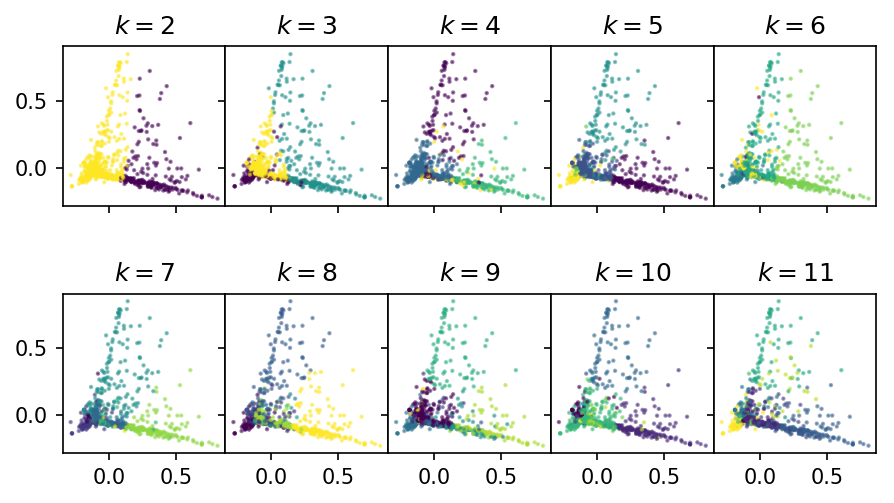

In [48]:
fig, ax = plt.subplots(2, 5, dpi=150, sharex=True, sharey=True, figsize=(7,4),
                       subplot_kw=dict(aspect='equal'),
                       gridspec_kw=dict(wspace=0.0))
inertias = []
iidrs = []
scs = []

for i in range(2, 12):
#     kmeans = KMeans(n_clusters=i, random_state=1337)
    kmeans = MiniBatchKMeans (n_clusters=i, random_state=1337)
    y = kmeans.fit_predict(sk_res)
    
    inertias.append(kmeans.inertia_)
    iidrs.append(intra_to_inter(sk_res.values, y, euclidean, 50))
    scs.append(silhouette_score(sk_res, y))
        
    if i < 7:
        ax[0][i%7-2].scatter(sk_res[0], sk_res[1], s=5, c=y, alpha=0.5, marker='.')
        ax[0][i%7-2].set_title('$k=%d$'%i)
    else:
        ax[1][i%7].scatter(sk_res[0], sk_res[1], s=5, c=y, alpha=0.5, marker='.')
        ax[1][i%7].set_title('$k=%d$'%i)

### Interpreting the Results
As we can see from the above, we could speculate on which is the best $k$ value. However, we need to remember that our 2D visual representation may not actually represent the entire data set as these are only the first 2 principal components and we have a relatively high dimensional data so visual inspection alone would not be enough to determine the goodness of the clustering. 

And so we __use the Internal Validation Criteria__ that we talked about earlier in order to help determine the best k value. We plot these criteria for each k we did above.  

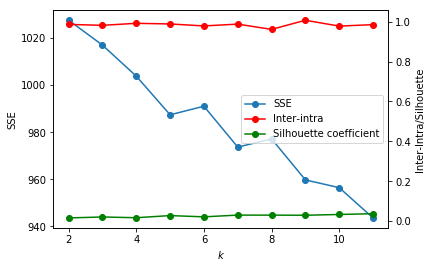

In [49]:
plt.plot(np.arange(2,12), inertias, '-o', label='SSE')
plt.xlabel('$k$')
plt.ylabel('SSE')
lines, labels = plt.gca().get_legend_handles_labels()
plt.twinx()
plt.plot(np.arange(2,12), iidrs, '-ro', label='Inter-intra')
plt.plot(np.arange(2,12), scs, '-go', label='Silhouette coefficient')


plt.ylabel('Inter-Intra/Silhouette')
lines2, labels2 = plt.gca().get_legend_handles_labels()
plt.legend(lines+lines2, labels+labels2);

#### Review for Criteria in choosing the best $k$
1. Sum of squares distances to centroids (__SSE__):  - the closer to 0 the better
	
2. Intracluster to intercluster distance ratio (__Inter-intra__):  - Small values of this measure indicate better clustering behavior. (closer to 0)

3. __Silhouette coefficient:__ 1 is really good, -1 is really bad, has to be at least 0.5 to be good.
   
### Deciding on the best $k$ value
As we can see, choosing the best k is sometimes not very straight forward and involves some degree of heuristics.

With the above, we observe:
1. The value for Inter-intra is fairly linear at or near +1. As the ideal value to this is supposed to be the closest to zero, the results being consistently "ugly" for this metrics gives us the impression that we can exclude this factor in this particular scenario.
2. Similar to Inter-intra, the Silhouette coefficient is fairly linear at or near 0. As the ideal value to this is supposed to be closest to one, the results again being consistent "ugly" for this metrics gives us the impression that we can exclude this as a selection factor for k.
3. We notice a sustained dip for k=5 coming from k=2 and followed by k=6. As a good value to SSE is one closest to zero however, we also have to consider that as k increases, SSE generally goes down to zero anyway. That said, what we generally look for are elbow scenarios where we can observe a dip in SSE. Here we see k=5, 7, and 9 as potentially good candidates. 

For the above reasons and in the interest of interpretability, __we will settle with choose k=5.__

### Replotting our clustered data-set according to $k$ value decided:

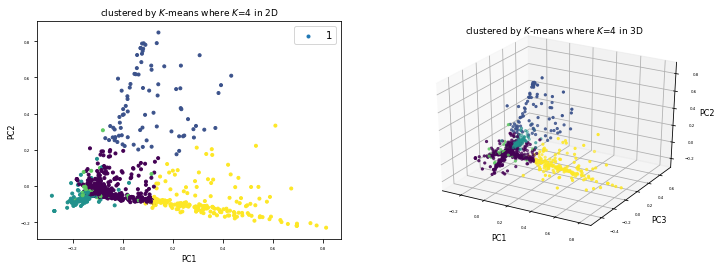

In [69]:
kmeans = KMeans(n_clusters=5, random_state=1337)
y_predict = kmeans.fit_predict(sk_res)

fig = plt.figure(figsize=(12,4))
fig.tight_layout()

ax1 = fig.add_subplot(121)
ax1.scatter(sk_res[0], sk_res[1], c=y_predict, marker='.')
ax1.tick_params(axis='both', which='major', labelsize=4)
ax1.set_title("clustered by $K$-means where $K$=4 in 2D", fontsize=9)
ax1.set_xlabel('PC1', fontsize=8)
ax1.set_ylabel('PC2', fontsize=8)
ax1.legend()

ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(sk_res[0], sk_res[2], sk_res[1], c=y_predict, marker='.')
ax2.tick_params(axis='both', which='major', labelsize=4)
ax2.set_title("clustered by $K$-means where $K$=4 in 3D", fontsize=9)
ax2.set_xlabel('PC1', fontsize=8)
ax2.set_ylabel('PC3', fontsize=8)
ax2.set_zlabel('PC2', fontsize=8, labelpad=-1);

### Time to Examine the Clusters!!!

we first __attach our cluster labels__ as determined by K-means to our original data set.

In [70]:
df_user['Cluster'] = y_predict
df_user.head()

,userID,post_tags,Cluster
6813,64740,c# entity-framework,0
5527,42108,sql sharepoint,1
4912,44437,java encryption load cpu,2
3724,37143,functional-programming nlp,0
6860,62255,image firefox png width line java video encode...,2


#### Examining the tags used on the posts commented on by individual users
I have highlighted the words in each cluster that from visual inspection, reveals the prevailing theme for each cluster.

In [71]:
clusters = 5
cluster_lst = {}
for i in range(clusters):
    cluster_lst[i] = df_user.loc[df_user['Cluster']==i]['post_tags'].tolist()

In [72]:
def fancyPrint(s, word, c=9):
    s = s.replace(word, '\x1b[1;3'+ str(c) + 'm' + word + '\x1b[0m')
    print(s)

### Cluster 0:

In [93]:
for i in range(30): fancyPrint(cluster_lst[0][i], '', 4)

c# entity-framework
functional-programming nlp
c++ memory pointers c++ puzzle operator-precedence
php perl dynamic variables unix shell php vim indentation regex vim keyboard-shortcuts perl hash coderef vim undo php mysql
vb.net git ignore ignorelist ignore-files
javascript metrics iframe https cross-domain security
python algorithm list winforms forms webforms html css html-lists html css html-lists http rest caching windows api usb javascript jquery c# html regex c# windows parallel-port c# algorithm arrays max design-patterns oop sql-server database database-design olap
linux linker
perl moose perl moose
closures computer-science grammar context-free-grammar
multithreading pthreads parallel-processing python ruby converter programming-languages functional-programming imperative programming-languages functional-programming imperative math combinatorics linear-programming math combinatorics linear-programming math combinatorics linear-programming math combinatorics linear-programming 

### Cluster 1:

In [88]:
for i in range(15): fancyPrint(cluster_lst[1][i], 'sql', 4)

sql sharepoint
linq-to-sql lambda group-by
asp.net javascript jquery web-services asp.net javascript jquery web-services sql sql-server sql-server-2005 sql sql-server sql-server-2005 asp.net html css stylesheet
database sql-server-2005 ms-access
asp.net sql-server python regex postal-code
.net sql sql-server sql-server-2005 web-services database database-design data-warehouse olap
c# sql ado.net c# sql ado.net c# sql ado.net
c# xml stored-procedures sql-server-ce compact-framework c# xml stored-procedures sql-server-ce compact-framework
.net multithreading process measurement cpu-cycles java string sql database join sql-limit
sql sql-server performance pagination
.net linq linq-to-sql
unix email unix email algorithm language-agnostic puzzle c# java .net clr jvm sql-server sql-server-2005 sql-server-2000 programming-languages dynamic-languages type-systems c# internet-explorer vba vb6 javascript flex java http python regex sql postgresql .net audio mono programming-languages functional-

### Cluster 2:

In [83]:
for i in range(20): fancyPrint(cluster_lst[2][i], 'java', 4)

java encryption load cpu
image firefox png width line java video encode decode playback javascript prototypejs java c++ algorithm firefox hash java c++ algorithm firefox hash
java rendering voxel
c# algorithm gis polygon distance c# algorithm gis polygon distance sql database java spring jdbc java xml xpath
java primes java regex regex-lookarounds
java math matrix performance java signal-processing numerical-analysis
pdf rtf java multithreading openoffice.org
amazon-s3 amazon-ec2 cloud flash video streaming flv java sockets networking connection socketexception java macos installer c eclipse eclipse-cdt ganymede project-management security encryption passwords java sockets localhost loopback serversocket sockets networking udp java compression java file-io java jsp servlets java-ee
javascript c geometry gridworld java python design-patterns programming-languages dynamic-typing
java xml
java memory-management java memory-management java class intellij-idea javadoc java generics strong-t

### Cluster 3:

In [85]:
for i in range(20): fancyPrint(cluster_lst[3][i], 'python', 4)

python audio mp3
python project-management wiki trac python project-management wiki trac svn migration repository externals python cherrypy algorithm compression
python metaclass language-agnostic plugins
vim ide editor gnu-screen php email mime php include filesystems python file locking python ruby programming-languages monkeypatching fluent-interface php xslt tags python exception sqlite apache tomcat webserver python django url templates templatetag python google-app-engine rest metaclass python soappy php django apache iis cookies django django-models naming-conventions python preprocessor template-engine freemarker fmpp javascript html string textbox listbox
python compiler-construction programming-languages interpreter python python pep8 vim coding-style c++ stl const maps c++ stl const maps c++ python algorithm diff c++ python algorithm diff python design configuration-files jquery css drag-and-drop html-table c++ c api sqlite char css html center css html center python perl co

### Cluster 4:

In [87]:
for i in range(20): fancyPrint(cluster_lst[4][i], '.net', 4)

asp.net asp.net-ajax autocompleteextender c# .net graphics raytracing
fonts development-environment asp.net vb.net json serialization .net-2.0 c# console fax windows command-line scripting batch-file text-files asp.net asp.net-mvc domain-name unicode ms-office security hash guid unique c# .net unicode ascii windows command-line unicode windows command-line unicode windows command-line unicode ruby-on-rails internet-explorer-6 regex email validation textmatching caching etag caching etag code-reuse actionscript-3 actionscript actionscript-2 c# email smtp bcc java string java string .net smtp gmail imap pop3 php seo sifr gd flir html flash unicode encoding outlook office-2007 .net email smtp system.net.mail .net email smtp system.net.mail flash actionscript-3 .net asp.net-mvc actionmethod asp.net-mvc language-agnostic visual-studio visual-studio-2005 stsadm psexec visual-studio visual-studio-2005 stsadm psexec windows visual-studio-2008 windows-7 c# crystal-reports fonts printing fax sel

## Conclusion: Determining what type of User Belongs to each Cluster

Looking at the above, we can now roughly make out the profile of the users based on the Clustering that we have done above and by looking at the tags on the posts that these individual users have commented on. The profiles of the Clusters being:
* __Cluster 0__: this one a bit difficult as we can't seem to see a pattern on the leaning the language preference of these users. As it looks like these users are into different language and tech platforms, we will classify these users as __multi-lingual / multi-platform__ users.
* __Cluster 1__: primarily composed of __sql__ leaning users
* __Cluster 2__: primarily composed of __java__ leaning users
* __Cluster 3__: primarily composed of __python__ leaning users
* __Cluster 4__: primarily composed of __.net__ leaning users

__These suggest that a lot of users have a language/platform leaning while some don't really have a strong leaning on language or platform.__


### References and Acknowledgements
* The concepts and most implementations applied here were taken from the classes of Professor Chris Alis, Assistant Professor Eduardo David, Professor Erika Legara, and Professor Chris Monterola of the AIM MSDS program class of 2019.
* Special thanks to the entire MSDS 2019 Cohort for misc ideas on how to approach this problem